This notebook is based on
https://pytorch.org/tutorials/beginner/nn_tutorial.html

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [3]:
print(x_train.size, x_train.shape)
print(x_valid.size, x_valid.shape)


39200000 (50000, 784)
7840000 (10000, 784)


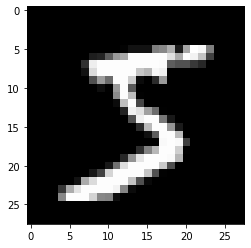

In [8]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0].reshape((28,28)), cmap='gray')

In [11]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(n,c)
print(y_train.shape)

50000 784
torch.Size([50000])


/home/amagi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [12]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5933, -2.5529, -2.5513, -2.1337, -2.9088, -2.0536, -1.6495, -2.5041,
        -2.1331, -2.5793], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [13]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3271, grad_fn=<NegBackward>)


In [14]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0938)


In [15]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [18]:
print(loss_func(model(x_valid), y_valid), accuracy(model(x_valid), y_valid))

tensor(0.2925, grad_fn=<NegBackward>) tensor(0.9183)


In [23]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F

loss_func = F.cross_entropy

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=64)

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=0.5)
    
model, opt = get_model()
print(loss_func(model(xb), yb))    

for epoch in range(5):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(x_valid), y_valid), accuracy(model(x_valid), y_valid))

tensor(2.3261, grad_fn=<NllLossBackward>)
tensor(0.2807, grad_fn=<NllLossBackward>) tensor(0.9231)
